In [2]:
using Pkg
Pkg.activate("..")
using DataFrames, DrWatson, HypothesisTests, LinearAlgebra, Parameters
using Printf, Query, SparseArrays, Statistics, StatsPlots

include(srcdir("load.jl"))
include(srcdir("power.jl"))

ENV["GKS_WSTYPE"] = "svg";

Activating environment at `~/dglmoore/yuji/Project.toml`


In [3]:
function results(col, fields::Symbol...)
    tempcol = Symbol(string(col) * "-sparse")
    
    df = collect_results(datadir("info", string(col)); verbose=false)
    disallowmissing!(df)
    
    filter!(r -> r[:gw] == 30 && r[:gh] == 30, df)

    select!(df, [:drug, :trial, :gh, :gw, :phase, fields..., col])

    df[!, :gridsize] = (df[:, :gh] .* df[:, :gw]).^2
    df[!, :μ] = mean.(df[:, col])
    df[!, :eigen] = (real ∘ last ∘ first ∘ eigen ∘ linearize).(df[:, col])
    
    select!(df, Not(col))
    df
end

results (generic function with 1 method)

In [9]:
macro infoplot(df, xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String,
               legend::Union{QuoteNode,Bool}=:(:topright))
    quote
        kf = $df |> @filter(_.drug == "K-gluconate")
        knf = $df |> @filter(_.drug == "K-gluconate:Nifedipine")
        
        marker=(:circ, 4, 1.0)
        color=[3 4]
        α=0.5

        kplot = @df kf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df kf violin!(kplot, $xcol, $ycol, group=:phase, α=α, color=color)

        knplot = @df knf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df knf violin!(knplot, $xcol, $ycol, group=:phase, α=α)

        xmin, xmax = extrema($df[:,$xcol])

        plot(kplot, knplot, layout=2, title=["K-gluconate" "K-gluconate + Nifedipine"], titleloc=:left,
             xlabel=$xlabel, xticks=xmin:xmax, ylabel=$ylabel, size=(1000,500), legend=$legend)
    end
end

macro infoplot(xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String, legend::Union{QuoteNode,Bool}=:(:topright))
    :(df -> @infoplot df $xcol $ycol $xlabel $ylabel $legend)
end

@infoplot (macro with 4 methods)

In [5]:
function powerhist(df, title, α, β)
    summary = by(df, [:drug], :ntrials => minimum, :ntrials => maximum, :ntrials => median)

    kplot = df |> @filter(_.drug == "K-gluconate") |> @df histogram(:ntrials, nbins=20, label="")
    summary |> @filter(_.drug == "K-gluconate") |> @df vline!(kplot, [:ntrials_median], label=first(:ntrials_median), linewidth=5)
    
    knplot = df |> @filter(_.drug=="K-gluconate:Nifedipine") |> @df histogram(:ntrials, nbins=20, label="")
    summary |> @filter(_.drug == "K-gluconate:Nifedipine") |> @df vline!(knplot, [:ntrials_median], label=first(:ntrials_median), linewidth=5)
    
    plot(kplot, knplot, layout=2, title=["$title K-gluconate ($α, $β)" "$title K-gluconate + Nifedipine ($α, $β)"], titleloc=:left,
         xlabel="Number of Trials", ylabel="Number of Analyses", size=(1000,500))
end

powerhist (generic function with 1 method)

In [6]:
mi = results(:mi, :lag);

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info/mi for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79


In [7]:
te = results(:te, :k);

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info/te for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79


In [17]:
α, β = 0.05, 0.80

(0.05, 0.8)

In [10]:
df = mi |> @filter(_.drug == "K-gluconate:Nifedipine" && _.lag==4) |> DataFrame
power(df[df[:,:phase] .== "before", :μ], df[df[:,:phase] .== "after", :μ])
# miμpowers = sort(by(mi, [:drug, :lag], [:phase, :μ] => x -> begin
#     μb = x.μ[x.phase .== "before"]
#     μa = x.μ[x.phase .== "after"]

0.2618388376088091

In [12]:
df = mi |> @filter(_.drug == "K-gluconate:Nifedipine" && _.lag==4) |> DataFrame
power(df[df[:,:phase] .== "before", :μ], df[df[:,:phase] .== "after", :μ]; unequalvar=false)
# miμpowers = sort(by(mi, [:drug, :lag], [:phase, :μ] => x -> begin
#     μb = x.μ[x.phase .== "before"]
#     μa = x.μ[x.phase .== "after"]

0.33952765421704323

# Mutual Information

## Mean Value

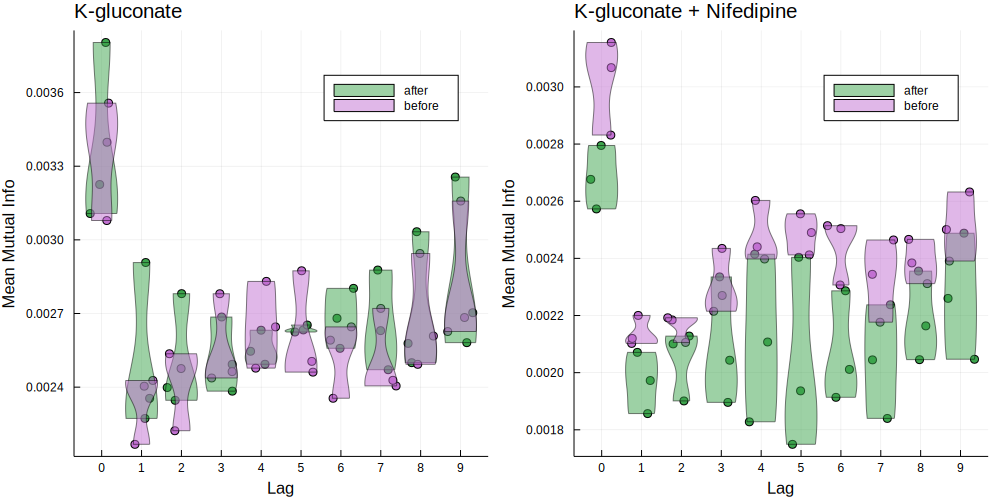

In [13]:
@infoplot mi :lag :μ "Lag" "Mean Mutual Info"

In [18]:
miμpowers = sort(by(mi, [:drug, :lag], [:phase, :μ] => x -> begin
    μb = x.μ[x.phase .== "before"]
    μa = x.μ[x.phase .== "after"]
    test = UnequalVarianceTTest(μb, μa)
    t, p = test.t, pvalue(test)
    ntrials = Int(ceil(solvepower(μb, μa, β, α)))
    (ntrials=ntrials, effect_size=effectsize(μb, μa), power=power(μb, μa), ts=t, p=p, reject=p < α)
end), [:drug, :lag])

,drug,lag,ntrials,effect_size,power,ts,p
,String,Int64,Int64,Float64,Float64,Float64,Float64
1,K-gluconate,0,2649,0.109561,0.051188,-0.134184,0.900724
2,K-gluconate,1,91,0.675559,0.0888821,-0.827388,0.475351
3,K-gluconate,2,137,0.47381,0.0728015,-0.580296,0.596217
4,K-gluconate,3,561,0.228449,0.0554472,0.279792,0.794141
5,K-gluconate,4,87,0.699975,0.0910536,0.857291,0.462717
6,K-gluconate,5,2947,0.146181,0.0514928,-0.179034,0.874286
7,K-gluconate,6,26,1.07495,0.172344,-1.31654,0.261852
8,K-gluconate,7,53,0.741697,0.108843,-0.90839,0.416116
9,K-gluconate,8,4245,0.0828267,0.0507174,-0.101442,0.924271


In [19]:
by(miμpowers, [:drug], :ntrials => minimum, :ntrials => maximum, :ntrials => median)

,drug,ntrials_minimum,ntrials_maximum,ntrials_median
,String,Int64,Int64,Float64
1,K-gluconate,26,5428,349.0
2,K-gluconate:Nifedipine,6,28,15.5


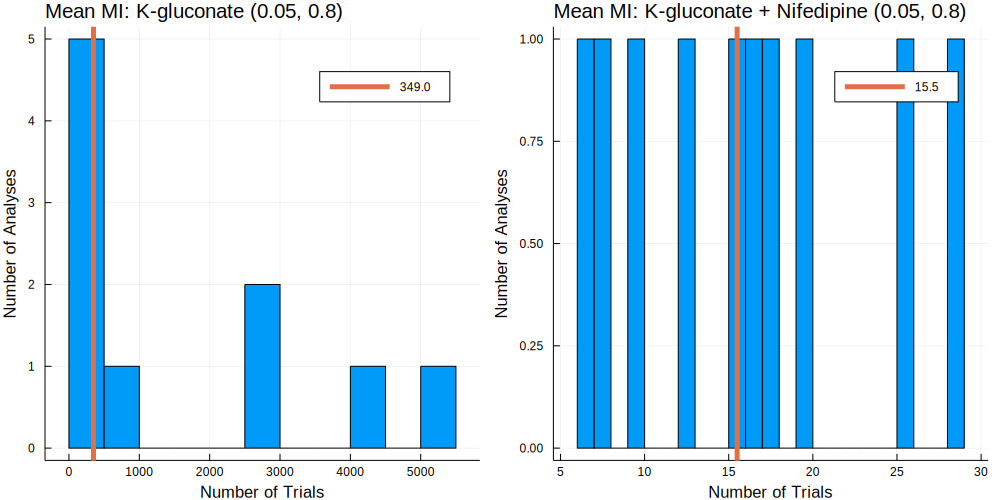

In [20]:
powerhist(miμpowers, "Mean MI: ", α, β)

## Largest Eigenvalue

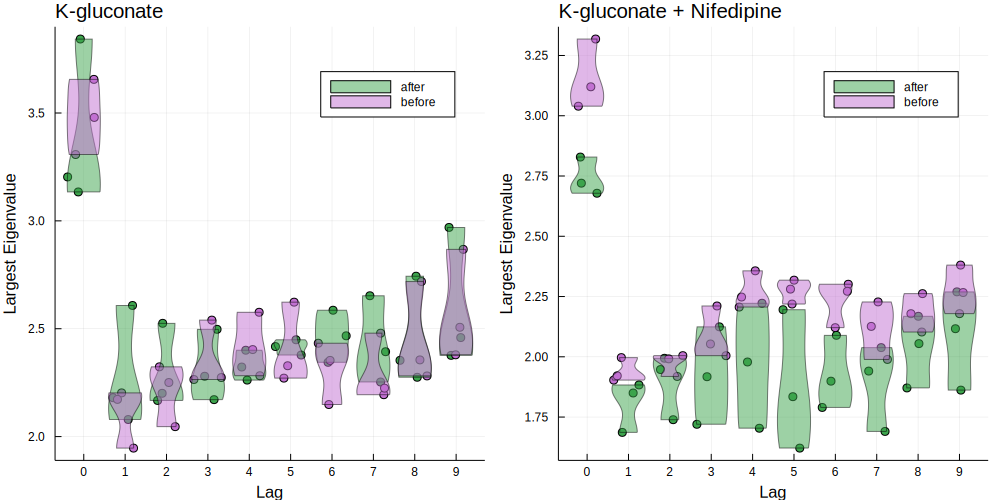

In [21]:
@infoplot mi :lag :eigen "Lag" "Largest Eigenvalue"

In [22]:
mieigenpowers = sort(by(mi, [:drug, :lag], [:phase, :eigen] => x -> begin
    eigenb = x.eigen[x.phase .== "before"]
    eigena = x.eigen[x.phase .== "after"]
    test = UnequalVarianceTTest(eigenb, eigena)
    t, p = test.t, pvalue(test)
    ntrials = Int(ceil(solvepower(eigenb, eigena, β, α)))
    (ntrials=ntrials, effect_size=effectsize(eigenb, eigena), power=power(eigenb, eigena), ts=t, p=p, reject=p < α)
end), [:drug, :lag])

,drug,lag,ntrials,effect_size,power,ts,p
,String,Int64,Int64,Float64,Float64,Float64,Float64
1,K-gluconate,0,475,0.288924,0.0572799,0.353858,0.748688
2,K-gluconate,1,56,0.820198,0.110976,-1.00453,0.390578
3,K-gluconate,2,110,0.526604,0.0784834,-0.644956,0.557196
4,K-gluconate,3,394,0.268521,0.0576884,0.328869,0.758808
5,K-gluconate,4,61,0.799732,0.106713,0.979468,0.403229
6,K-gluconate,5,20242,0.0529441,0.050205,-0.064843,0.953851
7,K-gluconate,6,23,1.14807,0.190823,-1.40609,0.234895
8,K-gluconate,7,55,0.737786,0.107028,-0.9036,0.420341
9,K-gluconate,8,54814,0.022757,0.0500551,-0.0278715,0.979106


In [23]:
by(mieigenpowers, [:drug], :ntrials => minimum, :ntrials => maximum, :ntrials => median)

,drug,ntrials_minimum,ntrials_maximum,ntrials_median
,String,Int64,Int64,Float64
1,K-gluconate,23,54814,252.0
2,K-gluconate:Nifedipine,3,78,18.5


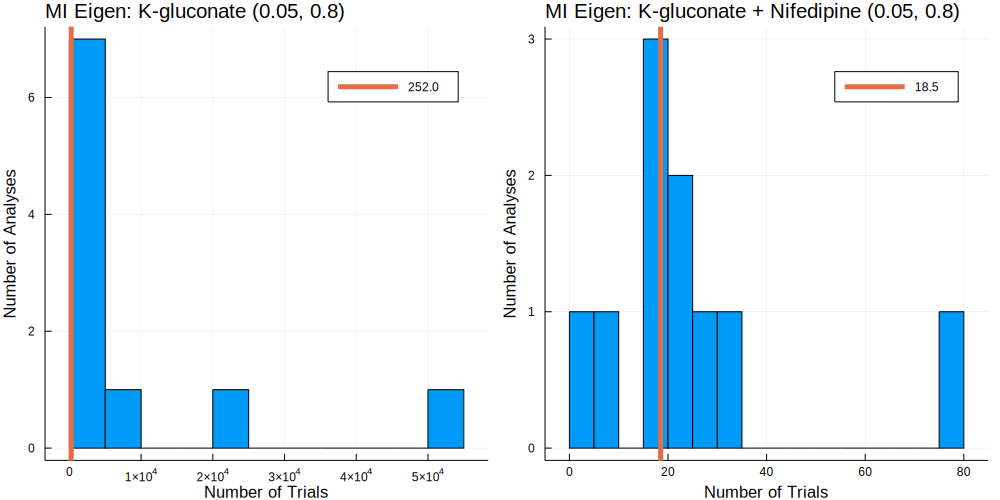

In [24]:
powerhist(mieigenpowers, "MI Eigen: ", α, β)

# Transfer Entropy

## Mean Value

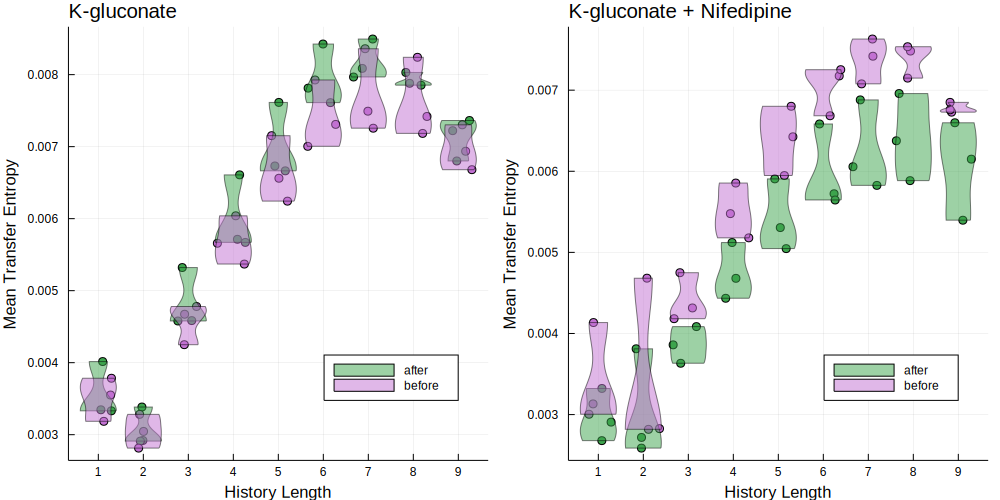

In [25]:
@infoplot te :k :μ "History Length" "Mean Transfer Entropy" :bottomright

In [26]:
teμpowers = sort(by(te, [:drug, :k], [:phase, :μ] => x -> begin
    μb = x.μ[x.phase .== "before"]
    μa = x.μ[x.phase .== "after"]
    test = UnequalVarianceTTest(μb, μa)
    t, p = test.t, pvalue(test)
    ntrials = Int(ceil(solvepower(μb, μa, β, α)))
    (ntrials=ntrials, effect_size=effectsize(μb, μa), power=power(μb, μa), ts=t, p=p, reject=p < α)
end), [:drug, :k])

,drug,k,ntrials,effect_size,power,ts,p
,String,Int64,Int64,Float64,Float64,Float64,Float64
1,K-gluconate,1,1090,0.164886,0.0528138,-0.201943,0.85042
2,K-gluconate,2,3073,0.096657,0.0509862,-0.11838,0.911585
3,K-gluconate,3,61,0.721454,0.102057,-0.883597,0.434097
4,K-gluconate,4,67,0.694673,0.0977108,-0.850797,0.450811
5,K-gluconate,5,58,0.706595,0.10344,-0.865399,0.436502
6,K-gluconate,6,20,1.19913,0.205751,-1.46863,0.21657
7,K-gluconate,7,35,1.05457,0.148777,-1.29158,0.290938
8,K-gluconate,8,98,0.770205,0.0923064,-0.943305,0.440281
9,K-gluconate,9,108,0.513405,0.0782551,-0.628791,0.563757


In [27]:
by(teμpowers, [:drug], :ntrials => minimum, :ntrials => maximum, :ntrials => median)

,drug,ntrials_minimum,ntrials_maximum,ntrials_median
,String,Int64,Int64,Float64
1,K-gluconate,20,3073,67.0
2,K-gluconate:Nifedipine,6,161,7.0


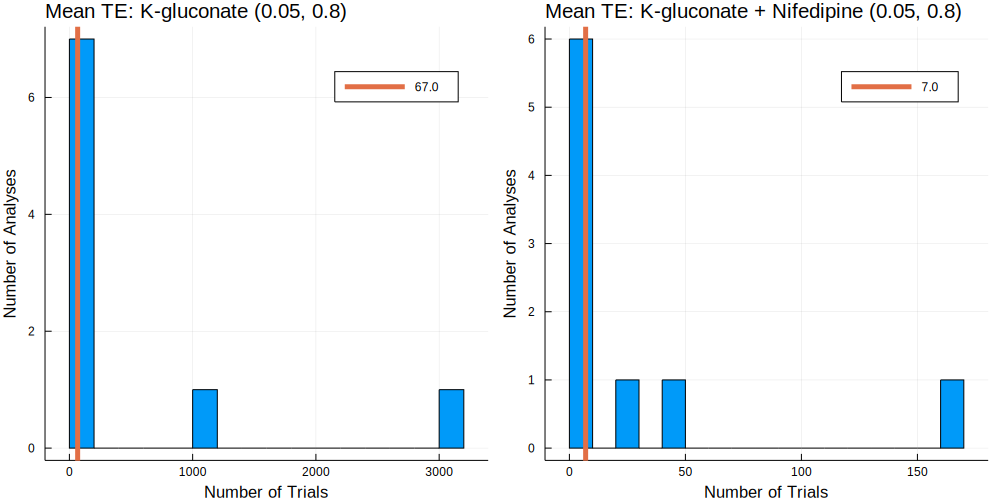

In [28]:
powerhist(teμpowers, "Mean TE: ", α, β)

## Largest Eigenvalue

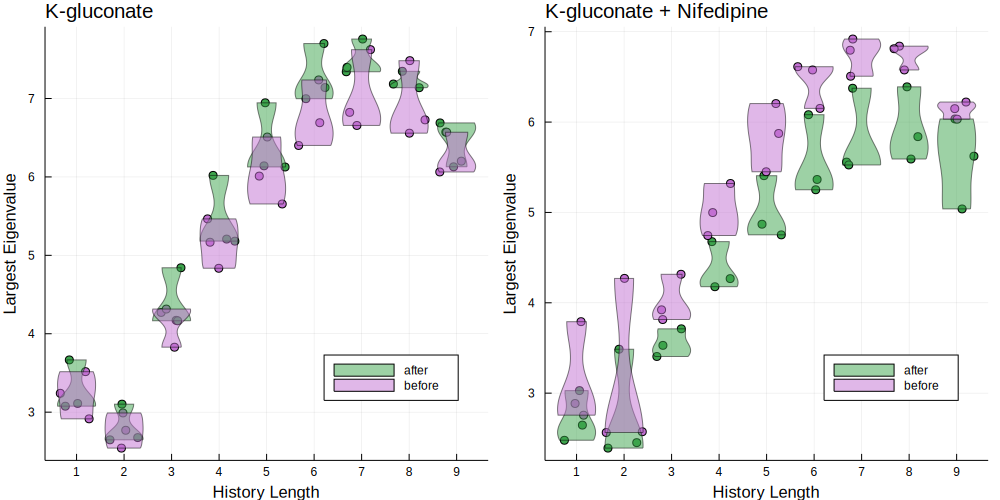

In [29]:
@infoplot te :k :eigen "History Length" "Largest Eigenvalue" :bottomright

In [30]:
teeigenpowers = sort(by(te, [:drug, :k], [:phase, :eigen] => x -> begin
    eigenb = x.eigen[x.phase .== "before"]
    eigena = x.eigen[x.phase .== "after"]
    test = UnequalVarianceTTest(eigenb, eigena)
    t, p = test.t, pvalue(test)
    ntrials = Int(ceil(solvepower(eigenb, eigena, β, α)))
    (ntrials=ntrials, effect_size=effectsize(eigenb, eigena), power=power(eigenb, eigena), ts=t, p=p, reject=p < α)
end), [:drug, :k])

,drug,k,ntrials,effect_size,power,ts,p
,String,Int64,Int64,Float64,Float64,Float64,Float64
1,K-gluconate,1,782,0.190857,0.0538696,-0.233751,0.826752
2,K-gluconate,2,956,0.173026,0.0531689,-0.211913,0.842695
3,K-gluconate,3,54,0.760508,0.108868,-0.931428,0.410372
4,K-gluconate,4,53,0.775888,0.110391,-0.950265,0.403392
5,K-gluconate,5,48,0.770459,0.114002,-0.943616,0.399184
6,K-gluconate,6,19,1.26069,0.221423,-1.54402,0.198673
7,K-gluconate,7,30,1.16503,0.166538,-1.42686,0.256948
8,K-gluconate,8,77,0.842401,0.101985,-1.03173,0.402159
9,K-gluconate,9,65,0.66332,0.0971471,-0.812398,0.462755


In [31]:
by(teeigenpowers, [:drug], :ntrials => minimum, :ntrials => maximum, :ntrials => median)

,drug,ntrials_minimum,ntrials_maximum,ntrials_median
,String,Int64,Int64,Float64
1,K-gluconate,19,956,54.0
2,K-gluconate:Nifedipine,6,170,7.0


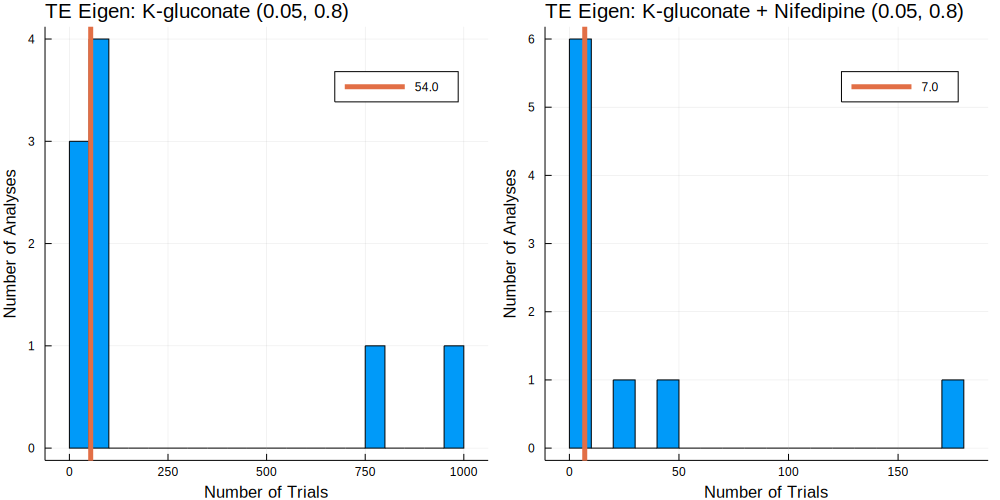

In [32]:
powerhist(teeigenpowers, "TE Eigen: ", α, β)